<a href="https://colab.research.google.com/github/Julianfried/Diplomatura-en-IA-Instituto-Humai/blob/main/Machine%20Learning/Clase_3_bias_variance_underfitting_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/MachineLearning/3_Regularizacion/bias-variance-underfitting-overfitting.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

# Sesgo y Varianza

### Intuiciones respecto a la relacion entre bias / variance / underfitting y overfitting

Generemos esto con un dataset sintético con una relacion cuadratica entre `x` e `y`

In [45]:
import numpy as np

def sample_data(size=100, x_matrix=False, min_x=-2.5, max_x=2.5):
    x = (np.random.random(size=size) - 0.5 ) * (max_x - min_x)
    x.sort() # util para graficar
    y = x ** 2 + x + np.random.normal(0, 1, size=size)
    if x_matrix:
        x = x.reshape((-1,1))
    return x, y

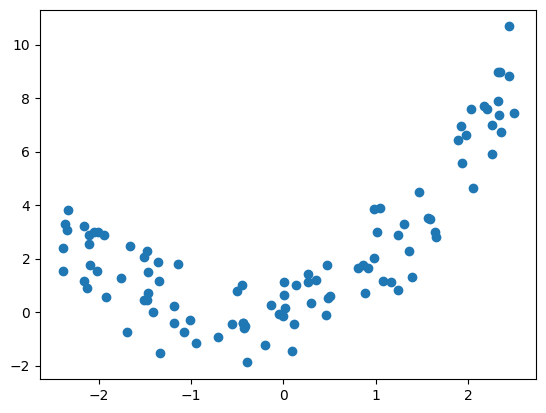

In [ ]:
import matplotlib.pyplot as plt

X, y = sample_data(size=100, x_matrix=True)
plt.scatter(X, y)

# Underfitting

Vamos a ajustar esta función cuadratica con una regresion lineal

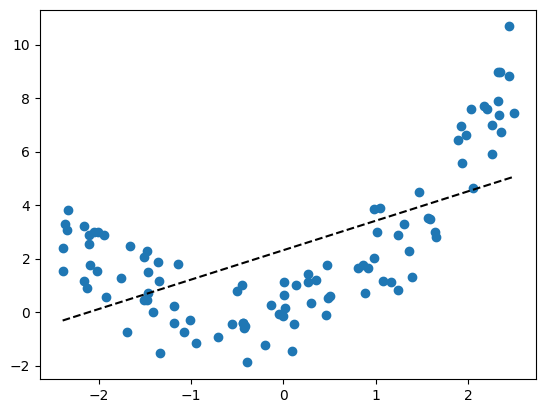

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X, y)

m, M = X.min(), X.max()

plt.plot([m, M], lr.predict([[m], [M]]), '--k')
plt.scatter(X, y)

Este es un caso típico de underfitting, la capacidad del modelo no es suficiente para explicar los datos

### Como se comporta con una parte de la distribución que nunca vio?

Vamos a evaluar la regresion lineal en un intervalo de datos que nunca vio, que involucran al `[-5, 5]` en lugar de `[-2.5, 2.5]` con lo que fue entrenado

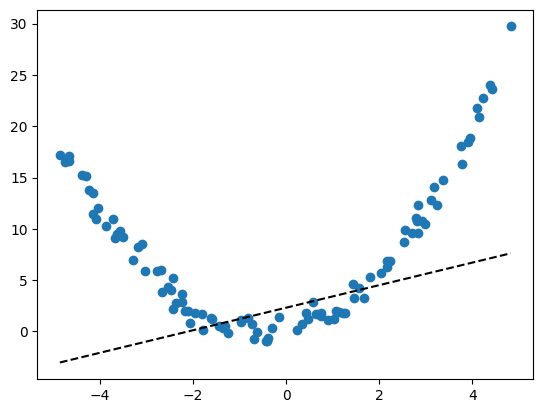

In [ ]:
oos_X, oos_y = sample_data(min_x=-5, max_x=5, x_matrix=True)

m, M = oos_X.min(), oos_X.max()
plt.plot([m, M], lr.predict([[m], [M]]), '--k')

plt.scatter(oos_X, oos_y)

La prediccion esta determinada por el sesgo que introdujimos nosotros. Este sesgo viene al determinar que el espacio de modelos que vamos a explorar, corresponde solo al de las funciones lineales en x

# Fiteamos muchos modelos lineales

Veamos como varian las predicciones si entrenamos muchos modelos lineales.

Podemos ver que el error es sistemáticamente alto

In [ ]:
def sample_predictions(model, x, iters=100):
    """
    Toma `iters` muestras de datos, entrena un modelo con esos datos
    Devuelve las predicciones de los modelos
    """
    ys_hat = []
    for _ in range(iters):
        X_train, y_train = sample_data(100, x_matrix=True)
        model.fit(X_train, y_train)
        ys_hat.append(model.predict(x))
    return np.asarray(ys_hat)

In [ ]:
def expected_prediction(model, x, iters=100):
    return sample_predictions(model, x, iters=iters).mean(axis=0)

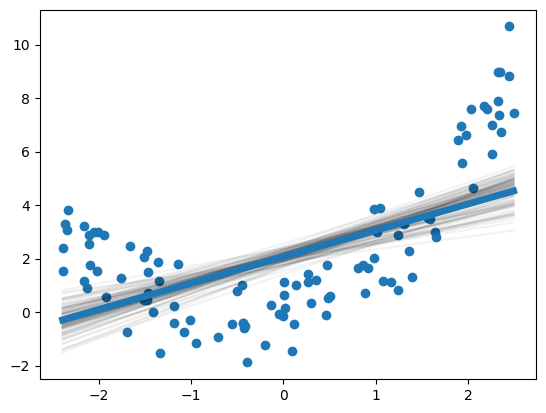

In [ ]:
ys = sample_predictions(LinearRegression(), X)
plt.plot(X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)
plt.plot(X, expected_prediction(LinearRegression(), X), lw=5)

Podemos ver que si bien con distintos samples de los datos se obtienen diferentes modelos, son todos bastante parecidos entre si, y hacen predicciones similares (baja varianza).

# Cambiando regresion lineal por arbol de decisión

interactive(children=(IntSlider(value=1, description='min_samples_leaf', max=50, min=1), Output()), _dom_class…

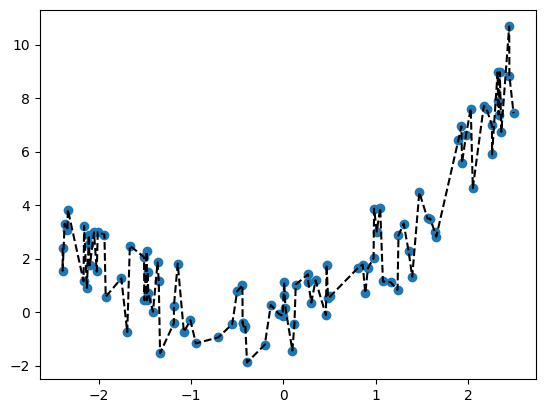

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from ipywidgets import interact, widgets

def draw(min_samples_leaf):
    dt = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf).fit(X, y)

    plt.plot(X, dt.predict(X), '--k')
    plt.scatter(X, y)

interact(
    draw,
    min_samples_leaf=widgets.IntSlider(min=1, max=50, step=1, value=1)
);

#### Que pasa si lo miramos con observaciones fuera del rango entrenado?

Podemos ver como se ajusta a la perfeccion a los datos

# Haciendo muchas predicciones

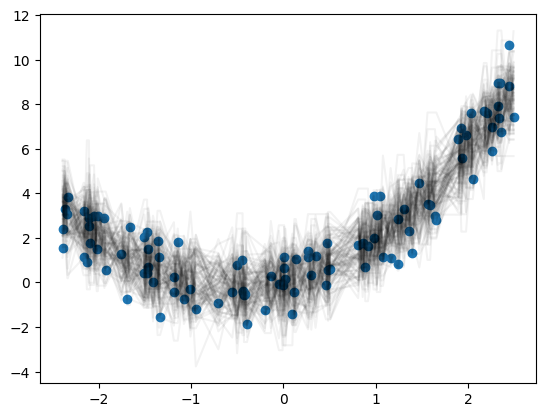

In [ ]:
ys = sample_predictions(DecisionTreeRegressor(), X)
plt.plot(X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)

Podemos ver que al tomar muchas muestras los modelos terminan cubriendo la zona de alta densidad de bolitas

Podemos ver que el modelo esperado se parece mucho a la funcion que genera los datos

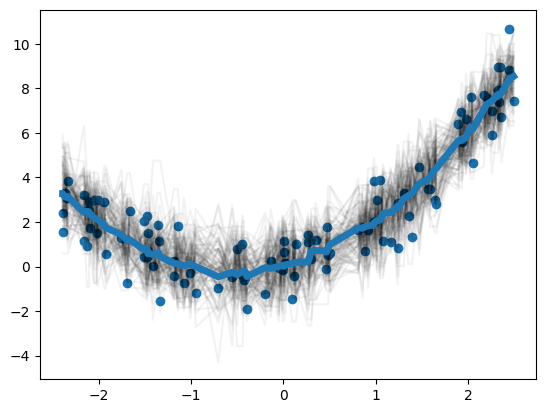

In [ ]:
ys = sample_predictions(DecisionTreeRegressor(), X)
plt.plot(X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)
plt.plot(X, expected_prediction(DecisionTreeRegressor(), X), lw=5)

Podemos ver que en esperanza el modelo le pega muy bien, sin embargo en cada realizacion del dataset

### Como se ve con observaciones out of sample?

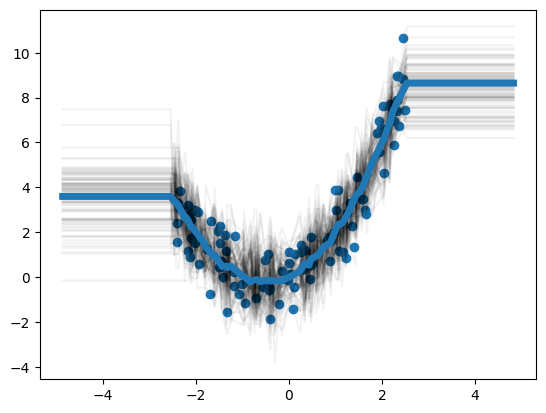

In [ ]:
ys = sample_predictions(DecisionTreeRegressor(), oos_X)
plt.plot(oos_X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)
plt.plot(oos_X, expected_prediction(DecisionTreeRegressor(), oos_X), lw=5)

# Calculando sesgo y varianza

![image.png](attachment:image.png)

Recordar que en las esperanzas de la segunda ecuacion son sobre las variables que estan en la expresion de MSE.

En este caso, por construccion **sabemos** el valor de `E[f(x)]`.
Es decir `E[f(x)] = x^2 + x` (ver funcion sample_data)

Con eso podemos calcular el sesgo y la varianza para este caso

In [ ]:
def bias(model, x, y, iters=1000):
    ideal_y = (x**2 + x).squeeze()
    errors = (
        ideal_y - expected_prediction(model, x, iters=iters)
    ) ** 2
    return errors.mean()

def variance(model, x, y, iters=1000):
    ideal_y = (x**2 + x).squeeze()
    # repetimos la esperanza en `iters` filas para facilitar el computo
    ideal_y = np.repeat(ideal_y.reshape((1, -1)), iters, axis=0)

    # sampleamos iters predicciones de modelos
    ys_hat = sample_predictions(model, x, iters=iters)

    # Estimamos la varianza por cada par (x_i, y_i) del dataset, luego promediamos las varianzas
    return np.var(ideal_y - ys_hat, axis=0).mean()

De esta forma podemos calcular el sesgo y la varianza de una regresion lineal

In [ ]:
bias(
    LinearRegression(),
    *sample_data(1000, x_matrix=True)
)

3.5082839795717975

In [ ]:
variance(
    LinearRegression(),
    *sample_data(1000, x_matrix=True)
)

0.11758606247354261

### Que pasa si jugamos con regularizacion L2?

A la regresion con regularizacion L2 se le suele llamar `Ridge`. El parámetro lambda en scikit-learn se llama alpha (a mas grande, mayor regularizacion)

In [ ]:
from sklearn.linear_model import Ridge

bias(
    Ridge(alpha=500),
    *sample_data(1000, x_matrix=True)
)

4.685694464261071

In [ ]:
variance(
    Ridge(alpha=500),
    *sample_data(1000, x_matrix=True)
)

0.062213385039927516

### Y podemos calcular el sesgo y la varianza de un decision tree

In [ ]:
bias(
    DecisionTreeRegressor(min_samples_leaf=1),
    *sample_data(1000, x_matrix=True),
)

0.0015869926514634407

In [ ]:
variance(
    DecisionTreeRegressor(min_samples_leaf=1),
    *sample_data(1000, x_matrix=True),
)

1.0087586465136145

Se puede ver que el decision tree tiene **muchisimo menos sesgo**, pero tiene una varianza 10 veces mas alta.

### Qué pasa si utilizamos min_samples_leaf = 10?

In [ ]:
bias(
    DecisionTreeRegressor(min_samples_leaf=10),
    *sample_data(1000, x_matrix=True),
    iters=1000
)

0.12802064662700915

In [ ]:
variance(
    DecisionTreeRegressor(min_samples_leaf=10),
    *sample_data(1000, x_matrix=True),
    iters=1000
)

0.4032976896115341

interactive(children=(IntSlider(value=10, description='min_samples_leaf', max=50, min=1), Output()), _dom_clas…

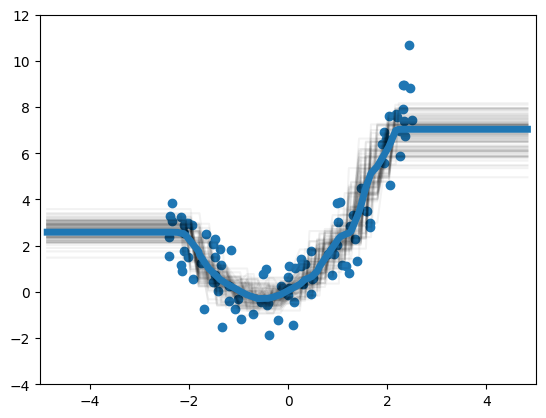

In [ ]:
from ipywidgets import interact, widgets

def draw_predictions(min_samples_leaf):
    ys = sample_predictions(
        DecisionTreeRegressor(min_samples_leaf=min_samples_leaf),
        oos_X,
        iters=100
    )
    plt.plot(oos_X, ys.T, color='k', alpha=0.05);
    plt.scatter(X, y)
    plt.plot(
        oos_X,
        expected_prediction(
            DecisionTreeRegressor(min_samples_leaf=min_samples_leaf),
            oos_X
        ),
        lw=5
    )
    plt.xlim(-5, 5)
    plt.ylim(-4, 12)


interact(
    draw_predictions,
    min_samples_leaf=widgets.IntSlider(min=1, max=50, step=1, value=10)
);

# Un modelo con el sesgo perfecto

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Ajustamos un modelo cuadrático
model = make_pipeline(PolynomialFeatures(), LinearRegression())

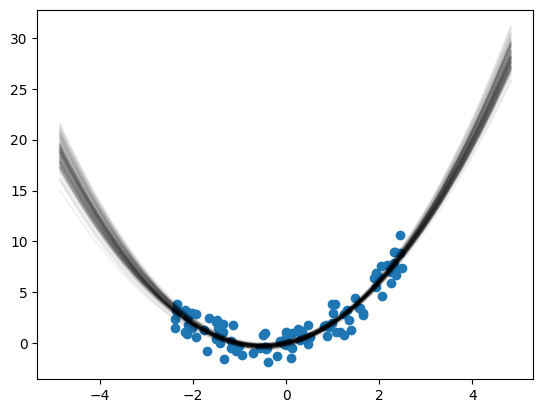

In [ ]:
ys = sample_predictions(model, oos_X)
plt.plot(oos_X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)

En este caso, al elegir el sesgo correcto, el modelo generaliza inclusive a datos nunca vistos de forma correcta.


En este caso tenemos un modelo de bajo sesgo y baja varianza (algo muy raro en la práctica).

Si bien este es un ejemplo de juguete, sirve para ejemplificar como un sesgo introducido de forma correcta al problema puede ser muy beneficioso en la calidad del modelo final

In [ ]:
bias(
    model,
    *sample_data(1000, x_matrix=True),
    iters=1000
)

9.290340744875117e-05

In [ ]:
variance(
    model,
    *sample_data(1000, x_matrix=True),
    iters=1000
)

0.029298607093717975

# Ejercicios

Para las siguientes afirmaciones, responder si son verdaderas o falsas programando el modelo y calculando los valores de sesgo y varianza

* Una Regresión Cúbica tiene menos sesgo y menos varianza que una Regresión Cuadrática. VERDADERO
* Random Forests tiene menos sesgo y menos varianza que Decision Tree. FALSO
* SVM con kernel lineal tiene menos sesgo y similar varianza que Regresion Lineal. FALSO
* SVM con kernel polinómico de grado 2 tiene mismo sesgo y varianza que Regresion Cuadrática. FALSO

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Obtener los datos
x, y = sample_data()

# Reshape de x
x = x.reshape(-1, 1)

# Crear las características polinómicas
quadratic_features = PolynomialFeatures(degree=2)
x_quadratic = quadratic_features.fit_transform(x)
cubic_features = PolynomialFeatures(degree=3)
x_cubic = cubic_features.fit_transform(x)

# Regresión Cuadrática
quadratic_regression = LinearRegression()
quadratic_regression.fit(x_quadratic, y)
quadratic_predictions = quadratic_regression.predict(x_quadratic)
quadratic_bias = np.mean((quadratic_predictions - y) ** 2)
quadratic_variance = np.var(quadratic_predictions)

# Regresión Cúbica
cubic_regression = LinearRegression()
cubic_regression.fit(x_cubic, y)
cubic_predictions = cubic_regression.predict(x_cubic)
cubic_bias = np.mean((cubic_predictions - y) ** 2)
cubic_variance = np.var(cubic_predictions)

# Imprimir resultados
print("Sesgo de Regresión Cuadrática:", quadratic_bias)
print("Sesgo de Regresión Cúbica:", cubic_bias)
print("Varianza de Regresión Cuadrática:", quadratic_variance)
print("Varianza de Regresión Cúbica:", cubic_variance)

Sesgo de Regresión Cuadrática: 1.3567997114361254
Sesgo de Regresión Cúbica: 1.3449274550861694
Varianza de Regresión Cuadrática: 4.366482686744614
Varianza de Regresión Cúbica: 4.378354943094568


In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

#Decision Tree

decision_tree = DecisionTreeRegressor()
decision_tree.fit(x,y)
decision_tree_predictions = decision_tree.predict(x)
decision_tree_bias = np.mean((decision_tree_predictions - y)**2)
decision_tree_variance = np.var(decision_tree_predictions)

#RandomForest

random_forest = RandomForestRegressor()
random_forest.fit(x,y)
random_forest_predictions = random_forest.predict(x)
random_forest_bias = np.mean((random_forest_predictions)**2)
random_forest_variance = np.var(random_forest_predictions)


 # Imprimir resultados
print("Sesgo de Decision Tree:", decision_tree_bias)
print("Sesgo de Random Forests:", random_forest_bias)
print("Varianza de Decision Tree:", decision_tree_variance)
print("Varianza de Random Forests:", random_forest_variance)

Sesgo de Decision Tree: 0.0
Sesgo de Random Forests: 7.208638331722377
Varianza de Decision Tree: 5.72328239818074
Varianza de Random Forests: 5.22240858831473


In [59]:
from sklearn.svm import SVR

#Regresion Lineal
lr= LinearRegression()
lr.fit(x,y)
lr_predictions = lr.predict(x)
lr_bias = np.mean((lr_predictions - y)*2)
lr_variance = np.var(lr_predictions)

#SVM con kernel lineal

svm_linear = SVR(kernel='linear')
svm_linear.fit(x,y)
svm_predictions = svm_linear.predict(x)
svm_linear_bias = np.mean((svm_predictions - y)**2)
svm_linear_variance = np.var(svm_predictions)

# Imprimir resultados
print("Sesgo de Regresión Lineal:", lr_bias)
print("Sesgo de SVM con kernel lineal:", svm_linear_bias)
print("Varianza de Regresión Lineal:", lr_variance)
print("Varianza de SVM con kernel lineal:", svm_linear_variance)

Sesgo de Regresión Lineal: 2.6645352591003756e-16
Sesgo de SVM con kernel lineal: 4.566902687497446
Varianza de Regresión Lineal: 1.3605715538927856
Varianza de SVM con kernel lineal: 0.5841960486951812


In [60]:
# Regresión Cuadrática
quadratic_features = PolynomialFeatures(degree=2)
x_quadratic = quadratic_features.fit_transform(x)

quadratic_regression = LinearRegression()
quadratic_regression.fit(x_quadratic, y)
quadratic_predictions = quadratic_regression.predict(x_quadratic)
quadratic_bias = np.mean((quadratic_predictions - y) ** 2)
quadratic_variance = np.var(quadratic_predictions)

#SVM con kernel polinomico de grado 2
svm_poly = SVR(kernel='linear', degree=2)
svm_poly.fit(x,y)
svm_poly_predictions = svm_poly.predict(x)
svm_poly_bias = np.mean((svm_poly_predictions)**2)
svm_poly_variance = np.var(svm_poly_predictions)

# Imprimir resultados
print("Sesgo de Regresión Cuadrática:", quadratic_bias)
print("Sesgo de SVM con kernel polinómico de grado 2:", svm_poly_bias)
print("Varianza de Regresión Cuadrática:", quadratic_variance)
print("Varianza de SVM con kernel polinómico de grado 2:", svm_poly_variance)


Sesgo de Regresión Cuadrática: 1.3567997114361254
Sesgo de SVM con kernel polinómico de grado 2: 2.069050340332404
Varianza de Regresión Cuadrática: 4.366482686744614
Varianza de SVM con kernel polinómico de grado 2: 0.5841960486951812
